In [1]:
%matplotlib inline

from glob import glob
import json
from typing import List

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize

In [19]:
import warnings
warnings.filterwarnings("ignore")

figsize(15, 9)
figsize(15, 9)

sns.__version__

'0.11.2'

In [3]:
def inner_product(row):
    return sum([g * p for g, p in row.items()])

In [26]:
result_files = glob("./results/*.json")

rows = []
for rf in result_files:
    with open(rf, "r") as istream:
        stats = json.load(istream)

    for name, history in stats.items():
        for g in history:
            rows.append({"guesses": g, "strategy": name})

df = pd.DataFrame(rows)

counts = df.assign(count=1).groupby(["strategy", "guesses"])[["count"]].sum().reset_index()
pivot_df = counts.pivot("strategy", "guesses", "count").fillna(0.0)
norm_pivot_df = pivot_df / pivot_df.sum(axis=1).max()
melted_df = norm_pivot_df.reset_index().melt(id_vars=['strategy'], value_name = 'probability')
norm_pivot_df['avg'] = norm_pivot_df.apply(inner_product, axis=1)
norm_pivot_df.sort_values(by='avg')

guesses,1,2,3,4,5,6,7,avg
strategy,,,,,,,,
StrategyMinMaxFeedbackMatches,0.000000,0.011663,0.171814,0.405832,0.265335,0.094060,0.051296,4.412203
StrategySmallestFeedbackPartition,0.000000,0.008099,0.168359,0.404968,0.264687,0.098596,0.055292,4.443197
StrategySmallestFeedbackPartitionV2,0.000000,0.009827,0.165011,0.320302,0.279914,0.132721,0.092225,4.637365
StrategyFirstGuessSoare,0.000000,0.015875,0.142333,0.309503,0.266523,0.154752,0.111015,4.734989
StrategyFirstGuessRoate,0.000000,0.016847,0.141253,0.301620,0.276242,0.154860,0.109179,4.738553
StrategyFirstGuessArise,0.000864,0.015551,0.141685,0.302700,0.273110,0.147516,0.118575,4.748488
StrategyFirstGuessSerai,0.000000,0.010151,0.137797,0.312095,0.271490,0.155292,0.113175,4.763499
StrategyFirstGuessRaise,0.000864,0.014363,0.141469,0.297408,0.273650,0.154104,0.118143,4.763499
StrategyMatchedFeedback,0.000108,0.011231,0.110907,0.291469,0.313499,0.171490,0.101296,4.826674


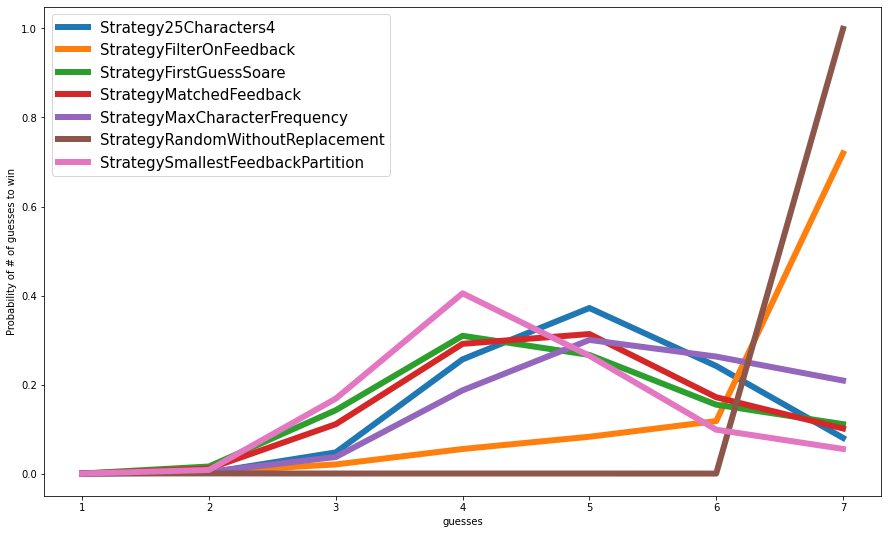

In [38]:
melted_df[
    ~melted_df['strategy'].isin([
#         "StrategyFilterOnFeedback",
        "StrategyFirstGuessAdieu",
        "StrategyFirstGuessArise",
        "StrategyFirstGuessAudio",
        "StrategyFirstGuessBoozy",
        "StrategyFirstGuessGypsy",
        "StrategyFirstGuessRaise",
        "StrategyFirstGuessRoate",
        "StrategyFirstGuessSerai",
#         "StrategyFirstGuessSoare",
#         "StrategyMatchedFeedback",
#         "StrategyMaxCharacterFrequency",
        "StrategyMaxEntropy",
        "StrategyMinMaxFeedbackMatches",
#         "StrategyRandomWithoutReplacement",
        "StrategyRandomWithReplacement",
#         "StrategySmallestFeedbackPartition",
        "StrategySmallestFeedbackPartitionV2",
        "Strategy25Characters0",
        "Strategy25Characters1",
        "Strategy25Characters2",
        "Strategy25Characters3",
#         "Strategy25Characters4",
    ])
]\
    .set_index("guesses")\
    .groupby('strategy')["probability"]\
    .plot(linewidth=6)
plt.legend(fontsize = 15)

plt.ylabel("Probability of # of guesses to win")

None